In [1]:
import numpy as np
import optimizer
import sinkhorn_ops
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment
%matplotlib inline
from time import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
data_train = input_data.read_data_sets('/tmp/', one_hot=True).train 
data_test = input_data.read_data_sets('/tmp/', one_hot=True).test 


/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


In [2]:
from scipy.special import logsumexp
def sinkhorn(log_alpha, n_iters=20):

    for n in range(n_iters):
        log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
        log_alpha -= logsumexp(log_alpha, axis=0, keepdims=True)
        if n%10000==1:
            print(n)
    log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
    return np.exp(log_alpha)

def batch_split(batch, n_squares_side, n_channels=1):
    if(n_channels ==1):
        #side = int(np.sqrt(batch.shape[1]))
        side =batch.shape[1]
    else:
        side = batch.shape[1]
    batch_size = batch.shape[0]
    n_squares = n_squares_side ** 2
    
    batch = np.reshape(batch, [-1, side, side, n_channels])
    batch = np.reshape(batch, [batch_size, n_squares_side, side/n_squares_side, side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    batch = np.reshape(batch, [batch_size, side/n_squares_side, n_squares, side/n_squares_side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    return batch

def stack_batch_split(batch):
    return np.reshape(batch, [batch.shape[0]*batch.shape[1], batch.shape[2], batch.shape[3], batch.shape[4]])


def unflatten_batch(batch, n_channels=1):
    side_square = int(np.sqrt(batch.shape[2]/n_channels))
    return np.reshape(batch, [batch.shape[0], batch.shape[1], side_square, side_square, n_channels])

def join_batch_split(batch):
    batch_size = batch.shape[0]
    n_squares = batch.shape[1]
    side_quare = batch.shape[2]
    n_channels = batch.shape[4]
    n_squares_side = int(np.sqrt(n_squares))
    batch = np.transpose(batch, [0, 1, 3, 2, 4])
    batch = np.reshape(batch, [batch_size, n_squares_side, side_square*n_squares_side, side_square, n_channels])
    batch = np.transpose(batch, [0,1, 3,2,4])
    batch = np.reshape(batch, [batch_size, 1, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    batch = np.reshape(batch, [batch_size, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    return batch

def resized_dims(n_squares_side):
    if(n_squares_side==2):
        side = 28
        side_square = 14
    if(n_squares_side==3):
        side = 27
        side_square = 9
    if(n_squares_side==4):
        side = 28
        side_square = 7
    if(n_squares_side==5):
        side = 30
        side_square = 6
    if(n_squares_side==6):
        side = 30
        side_square = 5
    if(n_squares_side==7):
        side = 28
        side_square = 4
    if(n_squares_side==8):
        side = 32
        side_square = 4
    if(n_squares_side==9):
        side = 27
        side_square = 3
    if(n_squares_side==16):
        side = 80
        side_square = 5
    if(n_squares_side==14):
        side = 196
        side_square = 14
    if(n_squares_side==18):
        side = 8*18
        side_square = 8
    if(n_squares_side==20):
        side = 7*20
        side_square = 7
    if(n_squares_side==25):
        side = 25*6
        side_square = 6
    if(n_squares_side==30):
        side = 30*5
        side_square = 5
    if (n_squares_side == 37):
        side = 37 * 4
        side_square = 4
    if (n_squares_side == 45):
        side = 45 * 3
        side_square = 3
    return side, side_square

def resize_batch_color(batch, side_new, n_channels):
    batch_new = np.zeros((batch.shape[0], side_new, side_new, n_channels))
    side = int(np.sqrt(batch.shape[1]))
    for i in range(batch.shape[0]):
        for c in range(n_channels):
            a = imresize(batch[i,:,:,c], [side_new, side_new])
            
            a = a/255.0
            batch_new[i,:,:,c] =a
    return batch_new


def soft_to_hard(soft_perm):
    
    a,b = linear_sum_assignment(-soft_perm)
    ma = np.zeros((np.shape(soft_perm)))
    for i in range(soft_perm.shape[0]):
        ma[i, b[i]] = 1
    return ma


def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data


In [3]:
# Define model params
batch_size = 50
n_iter_sinkhorn = 10

n_iter = 10000
temp = 0.5
temp2 =0.001

#mnist data
n_squares_side = 16
lr = 0.001
n_channels = 1
rfield_size = 3
stride = 3
n_units = 5
keep_prob = 1.0
side_real = 28
opt = 'adam'
samples_per_num = 1
batch_size_display = 10
n_samples_batch = 5

n_squares = n_squares_side **2
side, side_square = resized_dims(n_squares_side)
n_dim = int(side_square*side_square*n_channels)

n_dim_z = 256
n_dim_z2 = 256
n_dim_zp = 256

noise_factor = 0
np.random.seed(2)



25


In [4]:
#Now we define the main TF variables


real_split = tf.placeholder(tf.float32,[None, n_squares, side_square, side_square, n_channels])
real_split_tiled = tf.tile(real_split, [samples_per_num, 1, 1, 1, 1])
real_split_tiled = tf.reshape(real_split_tiled, [-1, n_squares, side_square ** 2* n_channels])

real_entire = tf.placeholder(tf.float32,[None, side_real, side_real, n_channels])
real_entire_tiled = tf.tile(real_entire,[samples_per_num,1,1,1])

global_step = tf.Variable(0, trainable=False)
stack_im = tf.placeholder(tf.float32,[None, side_square, side_square, 1])



In [5]:

def create_z():
    #create the matrix of log_alpha, that will later will converted into a soft permutation
    #this relies on some NN processing (convolutional), see below
    fc = tf.contrib.layers.fully_connected
    flatten = tf.contrib.layers.flatten
    dropout = tf.contrib.layers.dropout
    def conv(input_image, kernel_shape, bias_shape):
        weights = tf.get_variable("weights", kernel_shape,
                                 initializer = tf.random_normal_initializer())
        biases = tf.get_variable("biases", bias_shape, 
                                initializer=tf.constant_initializer(-1))
        convolutional = tf.nn.conv2d(input_image, weights, 
                                     strides = [1, 1, 1, 1],
                                     padding="SAME")
        out_relu = tf.nn.relu(convolutional + biases)
        out_maxpool = tf.nn.max_pool(out_relu, 
                                    ksize=[1, stride, stride, 1],
                                   strides=[1, stride, stride, 1],
                                   padding="SAME")
        return out_maxpool
    def conv_and_fc(input_image, scope, n_dim_z):
        with tf.variable_scope(scope):
            conv_output = conv(input_image, [rfield_size, rfield_size, n_channels, n_units], [n_units])
        fully_connected_output_mean = dropout(tf.cast(fc(flatten(conv_output), n_dim_z, activation_fn = None), tf.float32),
                                        keep_prob)
        fully_connected_output_log_var = dropout(tf.cast(fc(flatten(conv_output), n_dim_z, activation_fn = None), tf.float32),
                                        keep_prob)
      
        return fully_connected_output_mean, fully_connected_output_log_var
    
    #with tf.variable_scope("model_params"):
    z_mean, z_log_var = conv_and_fc(real_entire_tiled,'n1', n_dim_z)
    z_mean_pieces, z_log_var_pieces = conv_and_fc(real_entire_tiled,'n2',n_dim_zp)
    #z_mean_pieces, z_log_var_pieces = conv_and_fc(stack_im,'n2',n_dim_zp)
    z_mean_pieces = tf.reshape(tf.tile(z_mean_pieces, [1, n_squares]), [batch_size*n_squares,n_dim_zp])
    #z_mean_pieces = tf.reshape(z_mean_pieces, [1, n_squares]), [batch_size*n_squares,n_dim_zp])
    
    z_log_var_pieces = tf.reshape(tf.tile(z_log_var_pieces, [1, n_squares]), [batch_size*n_squares,n_dim_zp])
    z_pieces = z_mean_pieces + tf.random.normal([batch_size*n_squares, n_dim_zp]) *tf.exp(z_log_var_pieces/2)
    aa = fc(z_pieces,1, activation_fn = None)
    
    z_pieces_fc = tf.contrib.distributions.Bernoulli(logits=aa/temp).mean()
    scrambled_split_tiled = tf.tile(tf.reshape(z_pieces_fc, [batch_size, n_squares, 1]), [1,1, n_channels*side_square**2])
    
    z  = z_mean + tf.random.normal([batch_size, n_dim_z]) *tf.exp(z_log_var/2)
    z1 = tf.reshape(fc(z, n_squares*n_dim_z2, activation_fn = None), [-1, n_squares, n_dim_z2])
    z2 = tf.reshape(fc(flatten(z_pieces), n_dim_z2, activation_fn = None), [-1,  n_dim_z2,  n_squares])
    cost = tf.nn.sigmoid(tf.matmul(z1,z2))
   
    return z,z_pieces, z_mean, z_log_var, z_mean_pieces, z_log_var_pieces, cost, scrambled_split_tiled, aa,z_pieces_fc

In [6]:


#ordered_inf = tf.matmul(inv_soft_perms_flat, scrambled_split_tiled)

z,z_pieces, z_mean, z_log_var, z_mean_pieces, z_log_var_pieces, cost, scrambled_split_tiled,aa,z_pieces_fc = create_z()
(soft_perms_inf2, _) = sinkhorn_ops.gumbel_sinkhorn(-cost, temp2, samples_per_num, noise_factor, n_iter_sinkhorn, squeeze=False)
inv_soft_perms2 = tf.transpose(soft_perms_inf2, [0, 1, 3, 2])
inv_soft_perms2_flat = tf.reshape(tf.transpose(inv_soft_perms2, [1, 0, 2, 3]), [-1, n_squares, n_squares])

ordered_inf2 = tf.matmul(inv_soft_perms2_flat, scrambled_split_tiled)
 
rec_loss1 =tf.reduce_mean(tf.square(ordered_inf2 - real_split_tiled))
rec_loss =-tf.reduce_mean(tf.reduce_mean(real_split_tiled*tf.log(1e-5+ordered_inf2) +(1-real_split_tiled)*tf.log(1e-5+1-ordered_inf2),axis=0))*side_real**2

KL1 = 0.5 *tf.reduce_mean(tf.reduce_sum(1+z_log_var -tf.square(z_mean) -tf.exp(z_log_var), axis=1))
KL2 = 0.5 *tf.reduce_mean(tf.reduce_sum(1+z_log_var_pieces -tf.square(z_mean_pieces) -tf.exp(z_log_var_pieces), axis=1))
KL = KL1+KL2*n_squares
l2s_diff = rec_loss - KL

opt = optimizer.set_optimizer(opt, lr, opt_eps=1e-8)
train_op = tf.contrib.training.create_train_op(l2s_diff, opt, global_step=global_step)


Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:

init_op=tf.initialize_all_variables()
sess=tf.InteractiveSession()
sess.run(init_op)
new = tf.trainable_variables()

vals = []
for i in range(n_iter):
    if i<n_iter-1:
        ims,_=data_train.next_batch(batch_size)
    else:
        print('hola')
        ims,_=data_test.next_batch(batch_size)        
    ims = np.expand_dims(np.reshape(ims, [-1, 28,28]),axis=3)
    ims[ims>0.5]=1
    ims[ims<0.5]=0
    np_x = resize_batch_color(ims, side, n_channels)

    real_images_split = batch_split(np_x, n_squares_side, n_channels)
    stack_real_images_split = stack_batch_split(real_images_split)
    [o2,loss, rec_loss_np,KL_np,rec_loss1_np,_, sp2,cos,z_mean_pieces_np, z_pieces_fc_np,z_log_var_pieces_np,aa_np] = sess.run([ordered_inf2, l2s_diff,rec_loss,KL,rec_loss1,train_op, soft_perms_inf2,cost,z_mean_pieces,z_pieces_fc,z_log_var_pieces,aa],{real_split:real_images_split,real_entire:ims, stack_im:stack_real_images_split})
    if(i%10==0):
        val = [i, loss, rec_loss_np, KL_np, rec_loss1_np]
        vals.append(val)
        print(val)
    if i==n_iter-1:
        ogen = []
        sgen =[]
        scr =[]
        for k in range(n_samples_batch):
            [oo2,ssp2,scrambled_pieces_split_np] = sess.run([ordered_inf2,soft_perms_inf2, scrambled_split_tiled],{z:np.random.normal(0,1,(batch_size, n_dim_z)),
                                                                 z_pieces:np.random.normal(0,1,(n_squares*batch_size, n_dim_zp))})
            ogen.append(oo2)
            sgen.append(ssp2)
            scr.append(scrambled_pieces_split_np)
   


Instructions for updating:
Use `tf.global_variables_initializer` instead.
[<tf.Variable 'n1/weights:0' shape=(3, 3, 1, 5) dtype=float32_ref>, <tf.Variable 'n1/biases:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'fully_connected/weights:0' shape=(500, 256) dtype=float32_ref>, <tf.Variable 'fully_connected/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'fully_connected_1/weights:0' shape=(500, 256) dtype=float32_ref>, <tf.Variable 'fully_connected_1/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'n2/weights:0' shape=(3, 3, 1, 5) dtype=float32_ref>, <tf.Variable 'n2/biases:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'fully_connected_2/weights:0' shape=(500, 256) dtype=float32_ref>, <tf.Variable 'fully_connected_2/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'fully_connected_3/weights:0' shape=(500, 256) dtype=float32_ref>, <tf.Variable 'fully_connected_3/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'fully_connected_4/weights:0' shape=(256, 1) d

/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


[0, 50577.06, 1421.1567, -49155.902, 0.51953566]
[10, 16023.254, 419.39203, -15603.862, 0.15681721]
[20, 11674.636, 382.34265, -11292.293, 0.13160524]
[30, 9324.966, 369.0585, -8955.907, 0.12592189]
[40, 7067.5337, 395.8677, -6671.666, 0.14244774]
[50, 6138.885, 352.86786, -5786.017, 0.11863015]
[60, 5693.5186, 375.68735, -5317.831, 0.1303486]
[70, 5283.005, 374.75864, -4908.246, 0.12903164]
[80, 4663.5815, 369.40915, -4294.1724, 0.12605973]
[90, 4269.968, 374.06998, -3895.898, 0.12782991]
[100, 3614.9749, 371.18832, -3243.7866, 0.1272942]
[110, 3474.6223, 381.5561, -3093.0662, 0.13395514]
[120, 3084.8022, 380.96588, -2703.8364, 0.13379438]
[130, 3126.0308, 357.90265, -2768.1282, 0.12046824]
[140, 2931.836, 376.27484, -2555.561, 0.13054572]
[150, 2811.5598, 385.21857, -2426.3413, 0.13400671]
[160, 2394.8489, 359.1369, -2035.7119, 0.12171294]
[170, 2539.7483, 366.92682, -2172.8215, 0.12481529]
[180, 2290.7017, 356.12628, -1934.5754, 0.11887905]
[190, 2227.7563, 360.44284, -1867.3136, 0.

[1600, 251.98515, 221.34409, -30.641071, 0.06975007]
[1610, 247.3871, 217.91605, -29.47105, 0.06804923]
[1620, 249.69882, 219.3238, -30.375008, 0.067405604]
[1630, 253.7463, 224.51064, -29.235664, 0.07019619]
[1640, 247.8709, 217.45285, -30.41805, 0.067587696]
[1650, 260.85352, 231.7939, -29.059624, 0.07352334]
[1660, 251.06363, 222.37416, -28.689476, 0.06993566]
[1670, 248.25104, 219.99571, -28.255331, 0.068878934]
[1680, 256.33862, 226.40834, -29.930292, 0.07162168]
[1690, 262.64816, 234.76974, -27.878431, 0.075055465]
[1700, 246.54108, 219.36424, -27.176836, 0.06785223]
[1710, 253.67416, 223.63168, -30.042484, 0.06895925]
[1720, 253.28119, 223.2144, -30.066782, 0.0703195]
[1730, 233.50331, 207.67905, -25.824259, 0.06369552]
[1740, 236.47125, 212.01672, -24.454533, 0.06599209]
[1750, 241.67413, 214.82428, -26.84986, 0.06739729]
[1760, 245.93867, 217.9472, -27.991474, 0.06851882]
[1770, 234.52347, 211.62222, -22.901237, 0.06577435]
[1780, 234.79742, 210.4415, -24.355934, 0.065562874]


[3160, 230.15894, 216.64807, -13.510862, 0.06819609]
[3170, 237.65906, 223.57832, -14.080732, 0.07180535]
[3180, 234.969, 220.05878, -14.910225, 0.07077218]
[3190, 236.53333, 221.84634, -14.686979, 0.07171654]
[3200, 241.11172, 223.06436, -18.047365, 0.07260348]
[3210, 248.22852, 232.93935, -15.289175, 0.07556975]
[3220, 241.2199, 225.9188, -15.301099, 0.07284632]
[3230, 240.43513, 225.94176, -14.493381, 0.072888054]
[3240, 232.23944, 218.92671, -13.312727, 0.069170535]
[3250, 240.41125, 225.50305, -14.908205, 0.07415865]
[3260, 225.826, 211.45105, -14.374958, 0.06602308]
[3270, 240.62474, 226.08755, -14.537191, 0.073219836]
[3280, 228.23569, 214.03358, -14.202103, 0.06686901]
[3290, 250.05457, 235.37018, -14.684388, 0.07769374]
[3300, 221.73868, 207.21425, -14.524432, 0.065621816]
[3310, 225.97073, 211.06018, -14.910549, 0.06680435]
[3320, 227.3847, 212.63673, -14.747967, 0.06788937]
[3330, 227.83461, 212.83438, -15.000223, 0.06718975]
[3340, 227.34161, 212.58528, -14.756334, 0.067722

[4720, 211.0368, 196.39284, -14.643974, 0.060146812]
[4730, 228.53989, 214.54907, -13.990818, 0.067428574]
[4740, 220.67265, 206.42055, -14.252107, 0.06485427]
[4750, 224.89801, 210.40881, -14.489196, 0.0660326]
[4760, 224.60944, 210.20757, -14.401867, 0.06659493]
[4770, 226.57729, 211.12062, -15.456663, 0.06686866]
[4780, 232.8192, 217.2439, -15.575303, 0.069159746]
[4790, 215.3472, 200.56697, -14.780231, 0.061719146]
[4800, 226.80907, 209.78564, -17.023422, 0.066215344]
[4810, 227.17953, 213.10846, -14.071069, 0.066860214]
[4820, 235.06067, 220.85417, -14.206497, 0.06980988]
[4830, 214.65958, 199.6031, -15.056465, 0.062380724]
[4840, 217.28394, 202.6647, -14.619234, 0.063280076]
[4850, 243.16397, 228.27534, -14.888633, 0.07394948]
[4860, 235.06381, 219.55756, -15.506258, 0.06917435]
[4870, 230.19218, 214.30388, -15.888306, 0.06861069]
[4880, 241.95837, 225.64096, -16.317413, 0.07090484]
[4890, 217.58598, 203.48393, -14.102047, 0.063878775]
[4900, 235.83409, 220.907, -14.927099, 0.071

[6280, 223.47424, 207.76312, -15.711121, 0.0663224]
[6290, 227.2903, 206.14874, -21.141562, 0.06531272]
[6300, 233.28513, 212.96973, -20.315401, 0.067882545]
[6310, 226.83418, 208.3179, -18.516285, 0.06585162]
[6320, 215.08636, 198.26147, -16.824894, 0.062190764]
[6330, 214.77498, 198.72069, -16.05429, 0.062133186]
[6340, 224.99832, 210.12549, -14.872841, 0.06533661]
[6350, 224.4654, 209.2625, -15.202899, 0.06658633]
[6360, 228.21564, 211.9135, -16.302135, 0.06595636]
[6370, 230.16722, 214.86983, -15.297395, 0.06810886]
[6380, 227.13739, 212.23218, -14.905205, 0.06604701]
[6390, 230.46184, 214.95894, -15.502893, 0.0677855]
[6400, 231.2374, 216.25565, -14.981755, 0.06907385]
[6410, 220.97809, 205.86482, -15.113266, 0.06488814]
[6420, 226.05562, 209.85043, -16.205187, 0.06561181]
[6430, 224.8304, 209.40894, -15.421457, 0.0662227]
[6440, 227.62769, 210.66827, -16.95942, 0.065580875]
[6450, 215.55074, 198.55116, -16.999567, 0.062797256]
[6460, 232.96983, 216.43068, -16.53916, 0.067988314]


[7840, 218.27666, 204.0242, -14.252451, 0.06383792]
[7850, 221.93663, 207.26979, -14.666834, 0.065729976]
[7860, 219.44054, 204.8233, -14.617228, 0.06523857]
[7870, 211.39894, 196.68242, -14.716528, 0.06052505]
[7880, 209.64903, 195.86287, -13.7861595, 0.061198127]
[7890, 219.12553, 204.43825, -14.687281, 0.06506781]
[7900, 206.93364, 192.33101, -14.602629, 0.058858056]
[7910, 225.46465, 209.91219, -15.552465, 0.06787241]
[7920, 218.2481, 202.99925, -15.248842, 0.064375006]
[7930, 231.45508, 216.6078, -14.847279, 0.06854607]
[7940, 212.46613, 197.75882, -14.707305, 0.06102187]
[7950, 218.03487, 203.67487, -14.359995, 0.0643291]
[7960, 215.90288, 200.77759, -15.12529, 0.06380933]
[7970, 230.61678, 214.18738, -16.429396, 0.065631606]
[7980, 221.93295, 206.20479, -15.728158, 0.06453998]
[7990, 210.98207, 195.93512, -15.046951, 0.060997926]
[8000, 219.99341, 205.10977, -14.88364, 0.0657021]
[8010, 222.22974, 206.09453, -16.135208, 0.064734586]
[8020, 231.15137, 215.06055, -16.090816, 0.068

[9390, 214.74646, 200.31235, -14.43411, 0.062881716]
[9400, 212.55077, 198.67299, -13.877773, 0.062297307]
[9410, 220.30058, 205.86952, -14.431064, 0.064007394]
[9420, 223.44414, 209.24065, -14.203495, 0.0663875]
[9430, 219.07297, 205.41074, -13.66223, 0.064607896]
[9440, 218.68965, 204.7245, -13.965155, 0.06369887]
[9450, 214.91292, 199.87009, -15.042826, 0.06308323]
[9460, 226.79427, 211.90938, -14.884881, 0.067891955]
[9470, 215.63536, 200.99309, -14.642273, 0.063862875]
[9480, 219.27588, 205.33052, -13.945364, 0.06513233]
[9490, 218.82278, 204.49428, -14.328505, 0.06345353]
[9500, 215.78076, 201.79654, -13.984218, 0.06440821]
[9510, 214.0954, 200.23904, -13.856353, 0.062290337]
[9520, 228.62166, 213.77469, -14.846963, 0.06739793]
[9530, 221.95325, 208.16731, -13.7859335, 0.066895925]
[9540, 218.74402, 204.55286, -14.1911545, 0.06496958]
[9550, 208.33653, 194.91951, -13.417027, 0.06100614]
[9560, 216.7261, 202.81567, -13.910439, 0.062348805]
[9570, 209.47772, 195.25075, -14.226974, 

In [58]:
print(np_x.shape)

(50, 80, 80, 1)


In [44]:

joined_hard_all = []
joined_soft_all = []
joined_scrambled_all = []

for ind in range(n_samples_batch):
    
    hard = np.zeros(sp2.shape)
    scrambled_pieces = unflatten_batch(scrambled_pieces_split_np, n_channels)
    joined_scrambled = join_batch_split(scrambled_pieces)
    joined_scrambled_all.append(joined_scrambled)
    for i in range(batch_size_display):
        hard[i,0,:,:] =soft_to_hard(np.transpose(sgen[ind][i,0,:,:]))
    
    unscrambled_images_hard =  np.matmul(hard[:batch_size_display,0,:,:], np.reshape(scrambled_pieces[:batch_size_display,:,:,:], [batch_size_display,n_squares_side **2 ,-1]))
    unscrambled_images_soft =  ogen[ind]
    unflatten_inf_hard = unflatten_batch(unscrambled_images_hard, n_channels)
    joined_inf_hard = join_batch_split(unflatten_inf_hard)
    unflatten_inf_soft = unflatten_batch(unscrambled_images_soft, n_channels)
    joined_inf_soft = join_batch_split(unflatten_inf_soft)
    joined_soft_all.append(joined_inf_soft)
    joined_hard_all.append(joined_inf_hard)


(50, 80, 80, 1)


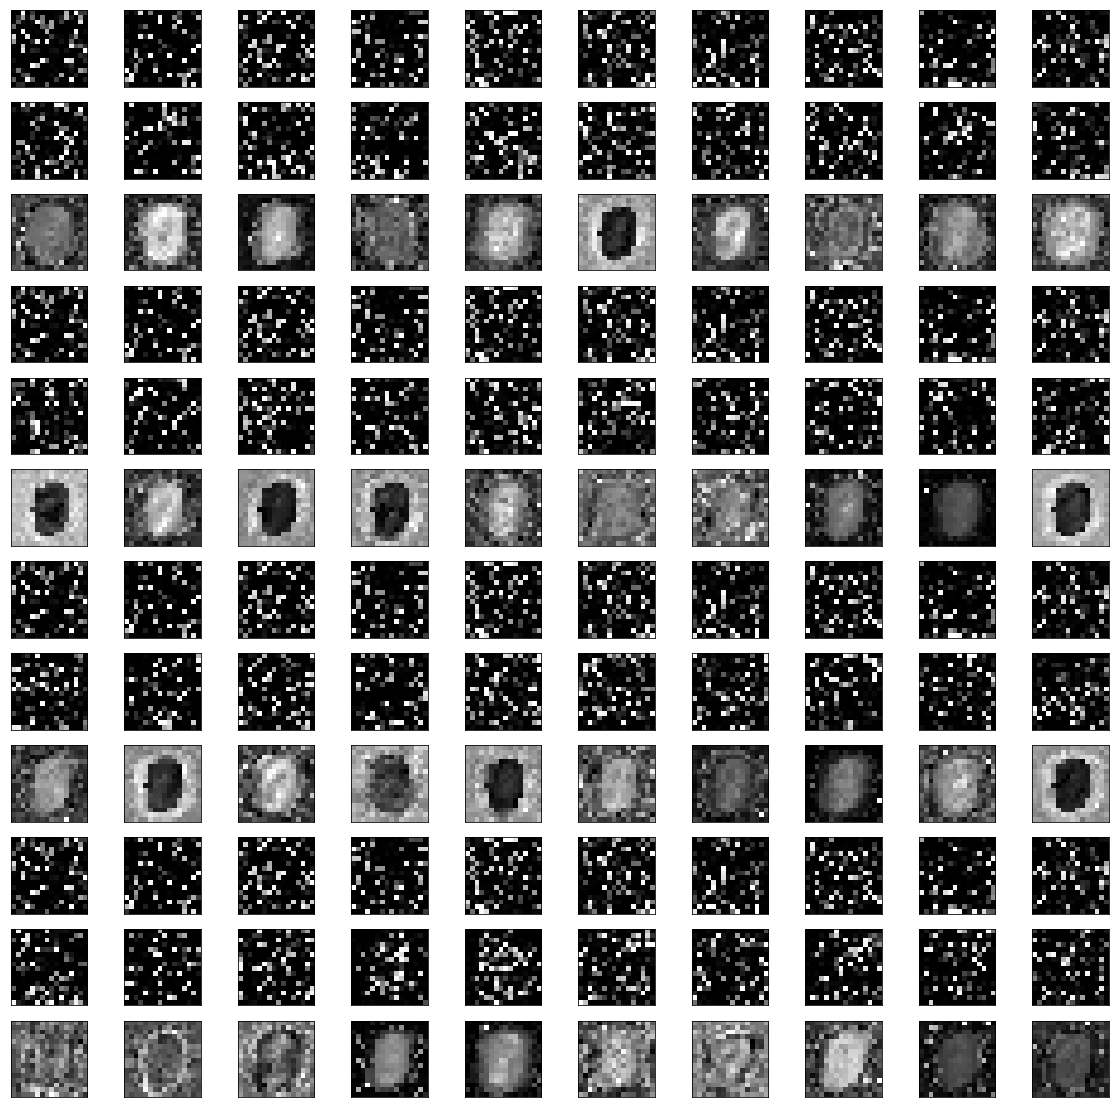

In [51]:
fig,ax=plt.subplots(3*ind,10,figsize=(20,20))
#plt.imshow(joined_inf[0,:,:,0])
print(np_x.shape)

for i in range(batch_size_display):
    
    for ind in range(n_samples_batch): 
        ax[1+3*(ind-1),i].imshow(joined_hard_all[ind][i,:,:,0],'gray')
        ax[2+3*(ind-1),i].imshow(joined_soft_all[ind][i,:,:,0],'gray')
        ax[0+3*(ind-1),i].imshow(joined_scrambled_all[ind][i,:,:,0],'gray')
        for k in range(3):
            ax[k+3*(ind-1),i].get_xaxis().set_visible(False)
            ax[k+3*(ind-1),i].get_yaxis().set_visible(False)
plt.savefig('samples.png')

(50, 80, 80, 1)


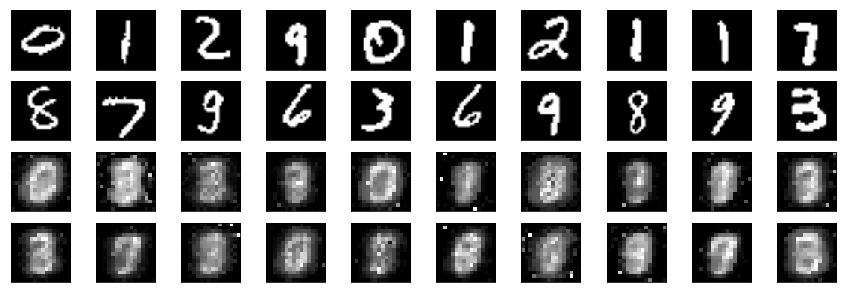

In [71]:
batch_display_size = 20
hard = np.zeros(sp2.shape)

unscrambled_images_soft =  o2
unflatten_inf_soft = unflatten_batch(unscrambled_images_soft, n_channels)
joined_inf_soft = join_batch_split(unflatten_inf_soft)

fig,ax=plt.subplots(4,10,figsize=(15,5))
#plt.imshow(joined_inf[0,:,:,0])
print(np_x.shape)
for i in range(batch_display_size):
    j1 = i%10
    j2 = int(i/10)
    ax[j2,j1].imshow(np_x[i,:,:,0],'gray')
    ax[j2+2,j1].imshow(joined_inf_soft[i,:,:,0],'gray')
    for k in range(4):
        ax[k,j1].get_xaxis().set_visible(False)
        ax[k,j1].get_yaxis().set_visible(False)
plt.savefig()

[0.9903103  1.0004516  0.9940706  0.992694   0.9903993  1.004932
 1.0052168  0.9944291  1.0051479  0.9974617  1.0060706  0.99785507
 0.9901956  1.0058198  1.0060115  0.9902016  1.0057607  1.0062315
 0.9902375  0.99888194 0.998821   0.9911909  1.0059382  1.006001
 0.9980707  1.0058684  0.99145675 1.000249   0.9922098  0.99077874
 1.0059607  1.0041668  0.9901018  1.0033875  0.99705267 0.9944722
 1.0063871  0.99112034 1.0060785  0.99740946 0.99657995 1.005799
 0.9952515  1.0003355  1.0044842  0.9902159  1.0023313  1.0058734
 1.0056952  1.0059702  0.9900712  0.9992317  0.9904592  1.0051992
 0.99757946 1.0059499  0.9902207  0.9902018  0.9954621  0.99971783
 1.0057751  1.0000815  0.99018276 1.0064348  0.9927926  1.0059711
 0.9901668  0.9972109  1.0058475  0.9908636  0.99108315 1.0055887
 1.0058804  0.9909629  0.99834293 0.99622196 0.9942415  1.0042555
 1.0006196  1.0043857  0.99089056 1.0056367  0.99754953 0.99249387
 1.0047872  0.99938637 1.0056311  0.99840933 0.9974087  0.99746007
 1.00579

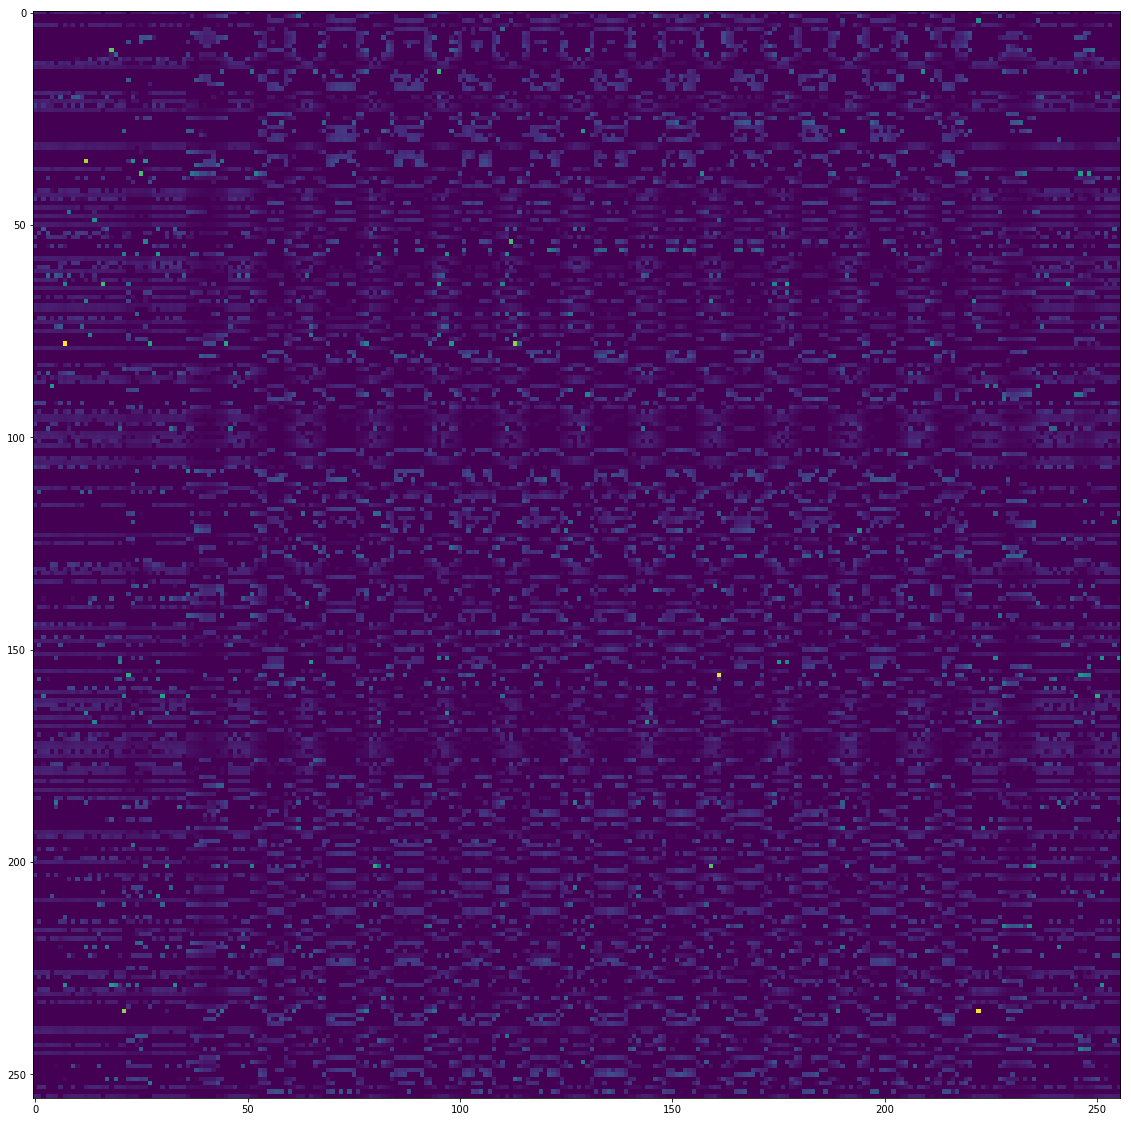

In [12]:
print(np.sum(ssp2[0,0,:,:], axis=1))
plt.figure(figsize=(20,20))
plt.imshow(ssp2[5,0,:,:])
print(ssp2[0,0,0,:])

In [13]:
print(np_x)

[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.

In [14]:

joined_inf_hard = join_batch_split(unflatten_batch(o2, n_channels))